In [134]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import requests
from datetime import date, datetime, timedelta
from io import StringIO

from arable.client import ArableClient
from lib.physics import *

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

font = {'size'   : 12}

matplotlib.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [334]:
# grab some mark data
email = 'danielle@arable.com'
device = 'A000176' 
a = ArableClient()
a.connect(email, 'arable1', 'arable')

sta = "2017-06-22 00:00:00"
end = "2017-10-06 00:00:00"
#end = datetime.now()
#end = end.strftime("%Y-%m-%dT%H:%M:%SZ")

df = a.query(select='all', 
               format='csv', devices=[device], 
               measure="calibrated", 
               order="time", 
               end=end, start=sta, 
               limit=30000) 

df = StringIO(df)
df = pd.read_csv(df, sep=',', error_bad_lines=False)

df['ts'] = df['time']
df['time'] = pd.to_datetime(df['time'])
df.index = df['time']

In [335]:
# correction for SWP_filter
ab1r = -0.023376484432823724 - 0.025
ab2r = 0.05413827524239004 - 0.025
ab3r = 0.06772827334892995 - 0.025
ab4r = 0.06332962505962343 - 0.025
ab5r = 0.26198870426167015 - 0.1
ab6r = 0.390244574048309 - 0.1
ab7r = 0.2835035664120416 - 0.1
bb1r = 0.02857355898033478
bb2r = -0.06322657807079235
bb3r = -0.07887981422051278
bb4r = -0.07514042020677027
bb5r = -0.30285714491760835
bb6r = -0.4581406095226578
bb7r = -0.3296091695063234

# correction for SZA_filter
pb1r = np.poly1d([ 0.03034586, -0.04446117,  0.0147993 ])
pb2r = np.poly1d([-0.04922785,  0.06914522, -0.02113901])
pb3r = np.poly1d([-0.07428615,  0.10191156, -0.02930466])
pb4r = np.poly1d([-0.08544811,  0.12849343, -0.04502609])
pb5r = np.poly1d([-0.19713582,  0.241687  , -0.04930455])
pb6r = np.poly1d([-0.3009217 ,  0.37354539, -0.08035967])
pb7r = np.poly1d([-0.2235144 ,  0.28053707, -0.0626818 ])

In [336]:
SWc = SW_azimuth_corr_(df.SWdw, df.time.dt, df.lat, df.long)
SWP = SWpot_(df.time.dt, df.lat, df.long)
df['SWP_filter'] = SWc / SWP

psi = solar_psi_(df.time.dt, df.lat, df.long) # Solar Zenith Angle
cospsi = np.cos(psi)
psimax = solar_phi_(df.lat) - solar_delta_(df.time.dt, df.long)
cospsimax = cos(psimax)
df['SZA_filter'] = cospsi / cospsimax
df['cospsi'] = cospsi

SWP_correction=False
if not SWP_correction:
    df['b1r'] = df.B1uw / df.B1dw
    df['b2r'] = df.B2uw / df.B2dw
    df['b3r'] = df.B3uw / df.B3dw
    df['b4r'] = df.B4uw / df.B4dw
    df['b5r'] = df.B5uw / df.B5dw
    df['b6r'] = df.B6uw / df.B6dw
    df['b7r'] = df.B7uw / df.B7dw
else:
    df['b1r'] = df.B1uw / df.B1dw - (ab1r + bb1r*df.SWP_filter) - (pb1r(df.SZA_filter))
    df['b2r'] = df.B2uw / df.B2dw - (ab2r + bb2r*df.SWP_filter) - (pb2r(df.SZA_filter))
    df['b3r'] = df.B3uw / df.B3dw - (ab3r + bb3r*df.SWP_filter) - (pb3r(df.SZA_filter))
    df['b4r'] = df.B4uw / df.B4dw - (ab4r + bb4r*df.SWP_filter) - (pb4r(df.SZA_filter))
    df['b5r'] = df.B5uw / df.B5dw - (ab5r + bb5r*df.SWP_filter) - (pb5r(df.SZA_filter))
    df['b6r'] = df.B6uw / df.B6dw - (ab6r + bb6r*df.SWP_filter) - (pb6r(df.SZA_filter))
    df['b7r'] = df.B7uw / df.B7dw - (ab7r + bb7r*df.SWP_filter) - (pb7r(df.SZA_filter))

dR1dt = (df.b1r-df.b1r.shift(1))/df.b1r
dR2dt = (df.b2r-df.b2r.shift(1))/df.b2r
dR3dt = (df.b3r-df.b3r.shift(1))/df.b3r
dR4dt = (df.b4r-df.b4r.shift(1))/df.b4r
dR5dt = (df.b5r-df.b5r.shift(1))/df.b5r
dR6dt = (df.b6r-df.b6r.shift(1))/df.b6r
dR7dt = (df.b7r-df.b7r.shift(1))/df.b7r

df['dRdt'] = abs((dR1dt + dR2dt + dR3dt + dR4dt + dR5dt + dR6dt + dR7dt) / 7.)




In [337]:
# To get a calibration data set
#     get a set of unique days using Grouper and Normalize
#     day defined by solar_utc_offset calc
#     create localtime index using timeshift
#     iterate thru local days to collect df for each day
#     get highest quality data and calc mean
#     join daily table with calibrated and ffill the reflectances, careful not to contaminate days
#     subtract reflectances from mean
#     gather all days including looser quality data, compute regressions

# To do the corrections
#     in calibration
#         calc reflectances
#         apply regressions
#         make values (uw/dw and r) nan under some criteria
#     in aggregation
#         in all reflectances, skip the nan checks in calc_ndvi etc
#         add timeshifted reflectances
#         do time difference in reflectance
#         filter the obs using looser quality criteria
#         compute mean or medium
#         Group and Normalized to daily

In [338]:
# 1. make a small df with just unique days.
tdf = df[['time']]
tdf.index = tdf['time']
tdf = tdf.groupby(pd.Grouper(freq='D')).min()
#tdf = tdf.index.normalize()
# 2. add to this some columns for the daily band averages
tdf['b1r_'] = tdf['b2r_'] = tdf['b3r_'] = tdf['b4r_'] = tdf['b5r_'] = tdf['b6r_'] = tdf['b7r_'] = 0.
tdf['doy'] = doy_(tdf.index)

In [339]:
#tdf

In [340]:
# 3. subset a spectral df, and add a solar time column
# even if this is not exactly accurate for solar noon, it does give the relevant 24-hour period
sdf = df[['time','lat','long','SWdw','SWP_filter','SZA_filter','dRdt','Tair','cospsi','b1r','b2r','b3r','b4r','b5r','b6r','b7r']].copy()
sdf.index = sdf['time']

td = pd.to_timedelta(sdf.long.iloc[0]/360.*24. + eot[sdf.time.dt.dayofyear-1]/60., unit = 'h').to_pytimedelta()

#sdf['solartime'] = sdf.time + pd.Timedelta(hours=(sdf.long.iloc[0]/360.*24. + eot[sdf.time.dt.dayofyear-1]/60.))
sdf['solartime'] = sdf.time + td
sdf['solartime'] = pd.to_datetime(sdf['solartime'])
sdf.index = sdf['solartime']

In [341]:
# 4. loop thru days in tdf, select where df.localtime == tdf.time
    # 5a. get rid of bad data
    # 5b. calculate average
    # 6. write value to a col in tdf
for i in tdf.index:
    start = i
    end = start + pd.Timedelta('1 days')
    #sdf[start:end]
    mask = (sdf['solartime'] >= start) & (sdf['solartime'] < end) & (sdf['SWP_filter'] > 0.7) & (sdf['SZA_filter'] > 0.7) & (sdf['dRdt'] < 0.01) 
    #mask = (sdf['solartime'] >= start) & (sdf['solartime'] < end) & (sdf['SZA_filter'] > 0.97) 
    idf = sdf.loc[mask].copy()
    x = doy_(idf.solartime.dt)
    nt = np.sum((sdf['solartime'] >= start) & (sdf['solartime'] < end))
    nx = np.sum(mask)
    noon = np.trunc(np.mean(x))+0.5
    print i, nx, noon
    
    #fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

    
    for ib in range(1,8):
        bxr = 'b' + str(ib) + 'r'
        y = idf['b' + str(ib) + 'r']
        #line1 = axes.plot(x, y)

        if (nx >= 10):
            z = np.polyfit(x, y, 2)
            p = np.poly1d(z)
            tdf.loc[start, 'b' + str(ib) + 'r_'] = p(np.mean(x))
            #tdf.loc[start, 'b' + str(ib) + 'r_'] = np.median(y)
        else:
            tdf.loc[start, 'b' + str(ib) + 'r_'] = np.nan

2017-06-22 00:00:00 67 173.5
2017-06-23 00:00:00 55 174.5
2017-06-24 00:00:00 10 175.5
2017-06-25 00:00:00 49 176.5
2017-06-26 00:00:00 31 177.5
2017-06-27 00:00:00 19 178.5
2017-06-28 00:00:00 86 179.5
2017-06-29 00:00:00 38 180.5
2017-06-30 00:00:00 5 181.5
2017-07-01 00:00:00 52 182.5
2017-07-02 00:00:00 83 183.5
2017-07-03 00:00:00 76 184.5
2017-07-04 00:00:00 52 185.5
2017-07-05 00:00:00 86 186.5
2017-07-06 00:00:00 63 187.5
2017-07-07 00:00:00 24 188.5
2017-07-08 00:00:00 56 189.5
2017-07-09 00:00:00 86 190.5
2017-07-10 00:00:00 32 191.5
2017-07-11 00:00:00 27 192.5
2017-07-12 00:00:00 0 nan
2017-07-13 00:00:00 26 194.5
2017-07-14 00:00:00 31 195.5
2017-07-15 00:00:00 40 196.5
2017-07-16 00:00:00 25 197.5
2017-07-17 00:00:00 11 198.5
2017-07-18 00:00:00 33 199.5
2017-07-19 00:00:00 30 200.5
2017-07-20 00:00:00 15 201.5
2017-07-21 00:00:00 46 202.5
2017-07-22 00:00:00 1 203.5
2017-07-23 00:00:00 46 204.5
2017-07-24 00:00:00 41 205.5
2017-07-25 00:00:00 35 206.5
2017-07-26 00:00:00

In [342]:
# pre-7 make a copy of tdf for analysis
rdf = tdf.copy()

rdf['b1rm'] = (rdf.b1r_.shift(-1) + rdf.b1r_.shift(1))/2.
rdf['b2rm'] = (rdf.b2r_.shift(-1) + rdf.b2r_.shift(1))/2.
rdf['b3rm'] = (rdf.b3r_.shift(-1) + rdf.b3r_.shift(1))/2.
rdf['b4rm'] = (rdf.b4r_.shift(-1) + rdf.b4r_.shift(1))/2.
rdf['b5rm'] = (rdf.b5r_.shift(-1) + rdf.b5r_.shift(1))/2.
rdf['b6rm'] = (rdf.b6r_.shift(-1) + rdf.b6r_.shift(1))/2.
rdf['b7rm'] = (rdf.b7r_.shift(-1) + rdf.b7r_.shift(1))/2.

rdf.b4rm[np.isnan(rdf.b4rm) & np.isfinite(rdf.b4r_)] = rdf.b4r_
rdf.b6rm[np.isnan(rdf.b6rm) & np.isfinite(rdf.b6r_)] = rdf.b6r_

ndvim = (rdf.b6rm - rdf.b4rm) / (rdf.b6rm + rdf.b4rm)

/usr/local/Cellar/ipython@5/5.5.0_4/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/Cellar/ipython@5/5.5.0_4/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


(0, 1)

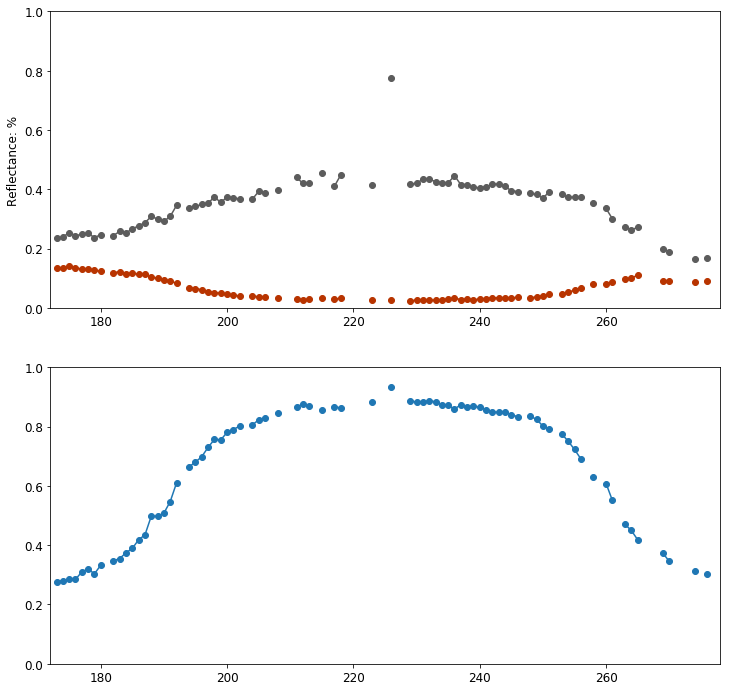

In [343]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,12))
#line1 = axes[0].plot(rdf.time, rdf.b1r_, color='#270dab', label = 'b1r')
#line2 = axes[0].plot(rdf.time, rdf.b2r_, color='#0dab86', label = 'b2r')
#line3 = axes[0].plot(rdf.time, rdf.b3r_, color='#a8ab0d', label = 'b3r')
line4 = axes[0].plot(rdf.doy, rdf.b4r_, color='#b83400', label = 'b4r')
line4 = axes[0].scatter(rdf.doy, rdf.b4r_, color='#b83400', label = 'b4r')

#line5 = axes[0].plot(rdf.time, rdf.b5r_, color='#8e4629', label = 'b5r')
line6 = axes[0].plot(rdf.doy, rdf.b6r_, color='#5c5c5c', label = 'b6r')
line6 = axes[0].scatter(rdf.doy, rdf.b6r_, color='#5c5c5c', label = 'b6r')

#line7 = axes[0].plot(rdf.time, rdf.b7r_, color='#00c2db', label = 'b7r')
#axes[0].legend(handles=[line1, line2, line3, line4, line5, line6, line7], loc=2)
axes[0].set_ylabel('Reflectance: %')
axes[0].set_ylim(0,1)
axes[0].set_xlim(np.min(rdf.doy)-1,np.max(rdf.doy)+1)

ndvi = (rdf.b6r_ - rdf.b4r_) / (rdf.b6r_ + rdf.b4r_)

line1 = axes[1].plot(rdf.doy, ndvi, label = 'ndvi')
line1 = axes[1].scatter(rdf.doy, ndvi, label = 'ndvi')
axes[1].set_xlim(np.min(rdf.doy)-1,np.max(rdf.doy)+1)
axes[1].set_ylim(0,1)



In [344]:
# To investigate:
# 2017-06-28 00:00:00 86 179.5
# 2017-06-29 00:00:00 46 180.5
# 2017-06-30 00:00:00 10 181.5

# 2017-07-07 00:00:00 26 188.5
# 2017-07-12 00:00:00 0 nan


In [345]:
np.std(rdf.b4r_-rdf.b4rm)

0.0018546797228991597

In [346]:
np.std(rdf.b6r_-rdf.b6rm)

0.007415370323361251

In [347]:
np.std(ndvi-ndvim)

0.007462673095601664

(0, 1)

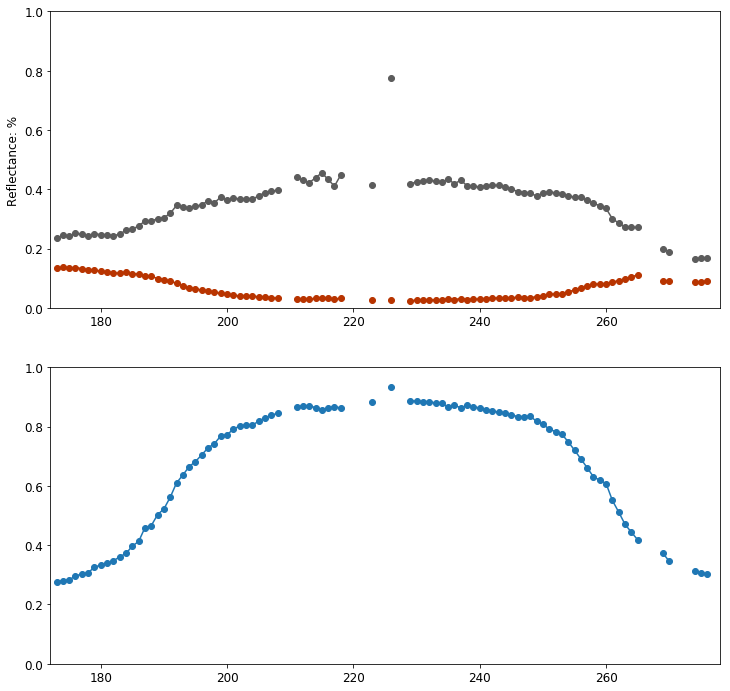

In [348]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,12))
line4 = axes[0].plot(rdf.doy, rdf.b4rm, color='#b83400', label = 'b4r')
line4 = axes[0].scatter(rdf.doy, rdf.b4rm, color='#b83400', label = 'b4r')

line4 = axes[0].plot(rdf.doy, rdf.b6rm, color='#5c5c5c', label = 'b4r')
line4 = axes[0].scatter(rdf.doy, rdf.b6rm, color='#5c5c5c', label = 'b4r')

axes[0].set_ylabel('Reflectance: %')
axes[0].set_ylim(0,1)
axes[0].set_xlim(np.min(rdf.doy)-1,np.max(rdf.doy)+1)

ndvi = (rdf.b6r_ - rdf.b4r_) / (rdf.b6r_ + rdf.b4r_)

line1 = axes[1].plot(rdf.doy, ndvim, label = 'ndvi')
line1 = axes[1].scatter(rdf.doy, ndvim, label = 'ndvi')
axes[1].set_xlim(np.min(rdf.doy)-1,np.max(rdf.doy)+1)
axes[1].set_ylim(0,1)

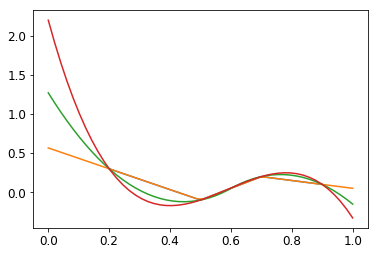

In [349]:
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.interpolate import InterpolatedUnivariateSpline

# # given values
# xi = np.array([0.2, 0.5, 0.7, 0.9])
# yi = np.array([0.3, -0.1, 0.2, 0.1])
# # positions to inter/extrapolate
# x = np.linspace(0, 1, 50)
# # spline order: 1 linear, 2 quadratic, 3 cubic ... 
# order = 1
# # do inter/extrapolation
# s = InterpolatedUnivariateSpline(xi, yi, k=order)
# y = s(x)

# # example showing the interpolation for linear, quadratic and cubic interpolation
# plt.figure()
# plt.plot(xi, yi)
# for order in range(1, 4):
#     s = InterpolatedUnivariateSpline(xi, yi, k=order)
#     y = s(x)
#     plt.plot(x, y)
# plt.show()